# Предсказание ДТП в каршеринге

Нужно создать систему для каршеринговой компании, которая могла бы оценить риск ДТП по совокупности факторов. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать виновность в ДТП, опираясь на исторические данные одного из регионов.

In [61]:
pip install -q pandas_profiling

Note: you may need to restart the kernel to use updated packages.


Шаги исполнения задачи:

<br>1) Загрузить таблицы 
<br>2) Исследовать таблицы
<br>3) Провести статистический анализ факторов ДТП
<br>4) Создать модель для оценки водительского риска
<br>5) Найти лучшую модель
<br>6) Проверить лучшую модель на тестовой выборке
<br>7) Сделать выводы

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
import lightgbm as lgb

from sqlalchemy import create_engine

import shap
import pandas_profiling
shap.initjs()

## Подключитесь к базе. Загрузите таблицы sql

In [5]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [7]:
engine = create_engine(connection_string)

In [8]:
collisions = '''

SELECT *
FROM collisions

'''

parties = '''

SELECT *
FROM parties

'''

vehicles = '''

SELECT *
FROM vehicles

'''

case_ids = '''

SELECT *
FROM case_ids

'''

In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [10]:
collisions = pd.read_sql_query(collisions, con = engine)

In [11]:
parties = pd.read_sql_query(parties, con = engine)

In [12]:
vehicles = pd.read_sql_query(vehicles, con = engine)

In [13]:
case_ids = pd.read_sql_query(case_ids, con = engine)

In [14]:
tables = [collisions, parties, vehicles, case_ids]

Итак, мы подключились к базе данных, и скачали и считали все таблицы, которые нам нужны. Также мы распределили таблицы в переменные.

## Проведите первичное исследование таблиц

In [15]:
def benchmark_analysis(table):
    print("Information:")
    print(table.info())
    print('-' * 50)
    
    print("First 5 rows:")
    print(table.head())
    print('-' * 50)

    print("Summary statistics:")
    print(table.describe())
    print('-' * 50)

    print("Shape:", table.shape)
    print('-' * 50)

    duplicates = table.duplicated().sum()
    print("Duplicate count:", duplicates)
    print('-' * 50)

    missing_values = table.isnull().sum().sum()
    print("Missing values count:", missing_values)

In [16]:
'''for table in tables:
    benchmark_analysis(table)'''

'for table in tables:\n    benchmark_analysis(table)'

Мы можем видеть, что в данных много пропусков и разные типы. Это значит, что на этапе подготовки нам нужно будет их обработать.

##  Проведите статистический анализ факторов ДТП

In [17]:
dtp = '''SELECT 
    EXTRACT(MONTH FROM COLLISION_DATE) AS MONTH,
    COUNT(*) AS NUM_COLLISIONS
FROM
    collisions
GROUP BY
    MONTH
ORDER BY
    NUM_COLLISIONS DESC;'''

count_collisions = pd.read_sql_query(dtp, con = engine)

In [18]:
count_collisions

,month,num_collisions
0,3.00,139581
1,1.00,132044
2,5.00,130316
3,4.00,130180
4,2.00,128858
5,10.00,112237
6,12.00,107945
7,9.00,105159
8,11.00,104770
9,8.00,104089


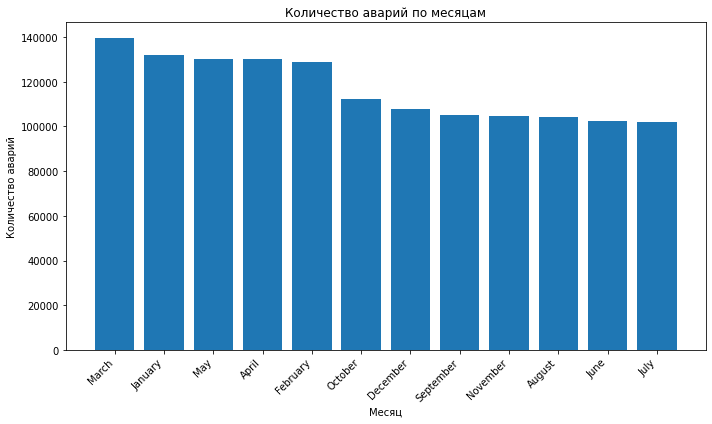

In [19]:
# Преобразуем числовой месяц в формат даты и получим название месяца
count_collisions['month'] = pd.to_datetime(count_collisions['month'], format='%m').dt.strftime('%B')

# Построение столбчатого графика
plt.figure(figsize=(10, 6))
plt.bar(count_collisions['month'], count_collisions['num_collisions'])
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.title('Количество аварий по месяцам')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Отображение графика
plt.show()

Мы видим, что разброс аварий небольшой по месяцам. Однако лидирует март, в котором было наибольшее количество аварий. Январь, Май, Апрель и Февраль распределены почти равномерно.

In [63]:
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.00,north,0.00,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.00,None,1.00,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.00,None,1.00,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399995,4082805,1502,kern,57.00,east,0.00,clear,None,middle damage,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,dark with no street lights,none,2009-01-17,21:04:00
1399996,4082820,1953,los angeles,0.00,None,1.00,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,14:20:00
1399997,4082829,1502,kern,0.00,None,1.00,clear,highway,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-17,18:06:00
1399998,4083008,4313,santa clara,20.00,east,NaN,clear,None,middle damage,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,dark with street lights,functioning,2009-01-06,17:53:00


In [65]:
collisions['collision_date'] = pd.to_datetime(collisions['collision_date'])

In [68]:
collisions['month'] = collisions['collision_date'].dt.month
collisions['year'] = collisions['collision_date'].dt.year

In [69]:
collisions.groupby(['year', 'month']).size()

year  month
2009  1        35062
      2        34480
      3        36648
      4        35239
      5        36916
      6        34202
      7        35161
      8        34508
      9        35555
      10       37835
      11       34562
      12       36060
2010  1        32892
      2        31918
      3        35803
      4        34416
      5        34862
      6        33367
      7        33645
      8        34620
      9        34957
      10       37480
      11       35460
      12       37070
2011  1        31926
      2        31975
      3        34585
      4        31377
      5        33370
      6        31962
      7        33029
      8        34339
      9        34137
      10       36618
      11       34495
      12       34615
2012  1        32020
      2        30377
      3        32498
      4        29143
      5        25168
      6         3062
      7          390
      8          622
      9          510
      10         304
      11         253
 

In [71]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

collisions['season'] = collisions['month'].apply(get_season)

In [72]:
collisions.groupby(['year', 'season']).size()

year  season
2009  Autumn    107952
      Spring    108803
      Summer    103871
      Winter    105602
2010  Autumn    107897
      Spring    105081
      Summer    101632
      Winter    101880
2011  Autumn    105250
      Spring     99332
      Summer     99330
      Winter     98516
2012  Autumn      1067
      Spring     86809
      Summer      4074
      Winter     62597
2013  Spring        51
      Summer         2
      Winter       252
2020  Spring         1
      Summer         1
dtype: int64

<AxesSubplot:xlabel='year'>

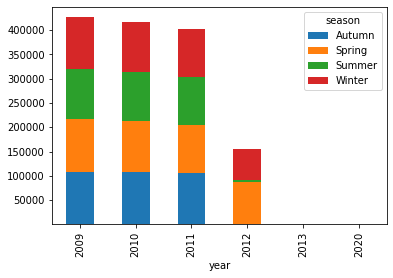

In [73]:
collisions.groupby(['year', 'season']).size().unstack().plot(kind='bar', stacked=True)

Данные по 2009, 2010 и 2011 году распределены равномерно. В эти года в сезоны заполняли одинаковое количество данных.

In [20]:
damage = '''SELECT
    c.ROAD_SURFACE,
    c.COLLISION_DAMAGE,
    COUNT(*) AS NUM_COLLISIONS
FROM
    collisions c
JOIN
    parties p ON c.CASE_ID = p.CASE_ID
GROUP BY
    c.ROAD_SURFACE, c.COLLISION_DAMAGE
ORDER BY
    c.ROAD_SURFACE, c.COLLISION_DAMAGE;'''

In [21]:
count_damage = pd.read_sql_query(damage, con = engine)

In [22]:
count_damage

,road_surface,collision_damage,num_collisions
0,dry,fatal,18219
1,dry,middle damage,288897
2,dry,scratch,658868
3,dry,severe damage,51115
4,dry,small damage,1450940
5,slippery,fatal,24
6,slippery,middle damage,344
7,slippery,scratch,544
8,slippery,severe damage,91
9,slippery,small damage,1230


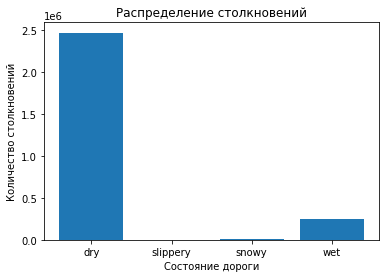

In [23]:
grouped_data = count_damage.groupby('road_surface')['num_collisions'].sum()

x_labels = grouped_data.index.tolist()

y_values = grouped_data.tolist()

plt.bar(x_labels, y_values)
plt.xlabel('Состояние дороги')
plt.ylabel('Количество столкновений')
plt.title('Распределение столкновений')

plt.show()

График говорит, что больше количество столкновений произошло на сухой дороге. Скорее всего, сухая дорога бывает чаще всего в любые времена года и машины по ней ездят чаще.

In [24]:
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.00,had not been drinking,None,0.00
1,23,3899454,2,road signs,0,7.00,had not been drinking,None,0.00
2,29,3899462,2,car,0,21.00,had not been drinking,None,0.00
3,31,3899465,2,road signs,0,24.00,had not been drinking,None,0.00
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.00
...,...,...,...,...,...,...,...,...,...
2752403,1549682,4981212,2,building,0,22.00,had not been drinking,None,NaN
2752404,1644472,5041069,2,building,0,13.00,had not been drinking,None,0.00
2752405,1906386,5181692,1,building,1,5.00,had not been drinking,None,0.00
2752406,2403824,5453437,2,building,0,30.00,had not been drinking,None,0.00


In [25]:
fault = '''SELECT party_type, COUNT(*) AS count
FROM parties
GROUP BY party_type
ORDER BY count DESC;'''

fault = pd.read_sql_query(fault, con = engine)

In [26]:
fault

,party_type,count
0,car,2469314
1,road bumper,173488
2,building,48649
3,road signs,48456
4,other,8879
5,None,3622


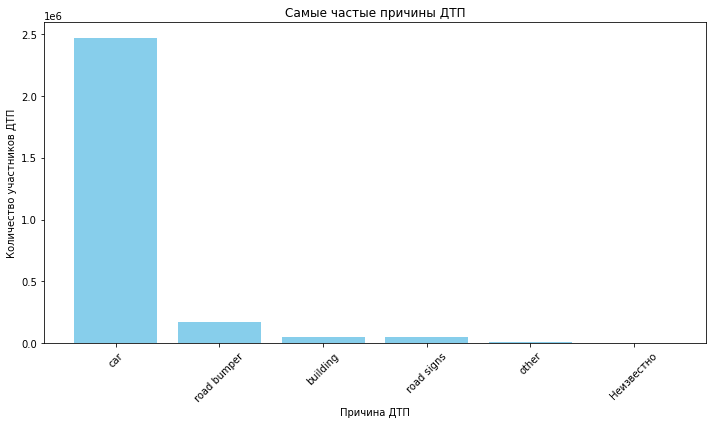

In [27]:
# Убедимся, что отсутствующие значения (None) заменены на строку "Неизвестно"
fault['party_type'] = fault['party_type'].fillna('Неизвестно')

# Данные из таблицы
party_type = fault['party_type']
count = fault['count']

# Создание графика
plt.figure(figsize=(10, 6))
plt.bar(party_type, count, color='skyblue')
plt.xlabel('Причина ДТП')
plt.ylabel('Количество участников ДТП')
plt.title('Самые частые причины ДТП')
plt.xticks(rotation=45)

# Отображение графика
plt.tight_layout()
plt.show()

Самая частая причина ДТП - столкновение с другой машиной.

### Задачи для коллег

**1)** Определить среднее время, прошедшее между происшествием и его регистрацией в таблице collisions.

**2)** Найти количество участников происшествия для каждого типа участника из таблицы parties и построить столбчатую диаграмму.

**3)** Сравнить средний возраст автомобилей, участвовавших в происшествиях с различными типами кузовов из таблицы vehicles.

**4)** Определить количество происшествий, в которых были замечены водители, находящиеся под воздействием наркотиков, из таблицы parties.

**5)** Найти количество происшествий, которые произошли на перекрестках и сравнить его с количеством происшествий, произошедших не на перекрестках, из таблицы collisions.

**6)** Подсчитать количество происшествий для каждого типа погоды из таблицы collisions и построить круговую диаграмму для визуализации результатов.

Для выполнения первой задачи нам нужно написать SQL-запрос, который объединит таблицы collisions и parties по общему идентификатору происшествия CASE_ID, а затем проанализирует данные и подсчитает количество участников происшествия для каждого типа участника.

In [28]:
query = '''SELECT p.PARTY_TYPE, COUNT(p.PARTY_TYPE) AS party_count
FROM collisions c
JOIN parties p ON c.CASE_ID = p.CASE_ID
GROUP BY p.PARTY_TYPE;'''

data = pd.read_sql_query(query, con = engine)

In [29]:
data.dropna(subset=['party_type'], inplace=True)

In [30]:
data

,party_type,party_count
0,building,48649
1,car,2469314
2,other,8879
3,road bumper,173488
4,road signs,48456


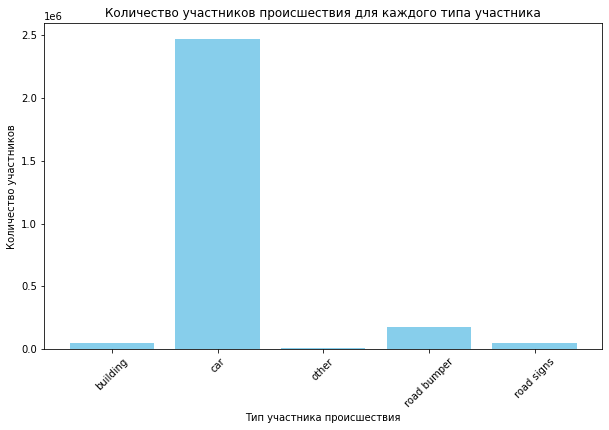

In [31]:
# Создадим столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(data['party_type'], data['party_count'], color='skyblue')
plt.xlabel('Тип участника происшествия')
plt.ylabel('Количество участников')
plt.title('Количество участников происшествия для каждого типа участника')
plt.xticks(rotation=45)

# Отобразим график
plt.show()

Из построенной столбчатой диаграммы можно сделать вывод, что тип участника происшествия "Car" (Авто) встречается чаще всего, а тип "Road bumper" (Дорожные знаки) наименее часто встречающийся.

Для выполнения второй задачи мы используем SQL-запрос для объединения таблиц collisions и vehicles по общему идентификатору происшествия CASE_ID и вычисления среднего возраста автомобилей для каждого типа кузова.

In [32]:
query = '''SELECT v.VEHICLE_TYPE, AVG(v.VEHICLE_AGE) AS AVG_VEHICLE_AGE
FROM collisions c
JOIN vehicles v ON c.CASE_ID = v.CASE_ID
GROUP BY v.VEHICLE_TYPE;'''

data = pd.read_sql_query(query, con = engine)

In [33]:
data

,vehicle_type,avg_vehicle_age
0,coupe,5.95
1,hatchback,5.27
2,minivan,4.69
3,other,5.74
4,sedan,4.39


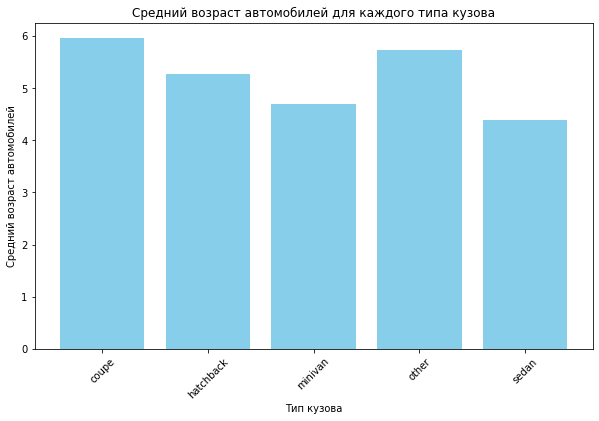

In [34]:
# Создаем столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(data['vehicle_type'], data['avg_vehicle_age'], color='skyblue')
plt.xlabel('Тип кузова')
plt.ylabel('Средний возраст автомобилей')
plt.title('Средний возраст автомобилей для каждого типа кузова')
plt.xticks(rotation=45)

# Отображаем график
plt.show()

Согласно полученным данным, средний возраст автомобилей для каждого типа кузова следующий:

- coupe (Купе) - 5.95 лет
- hatchback (Хэтчбек) - 5.27 лет
- minivan (Минивэн) - 4.69 лет
- other (Другое) - 5.74 лет
- sedan (Седан) - 4.39 лет

Исходя из этой информации, можно сделать предположение, что в среднем автомобили типа "minivan" (Минивэн) и "sedan" (Седан) более молодые, чем остальные типы кузовов. Автомобили типа "minivan" в среднем находятся на дорогах около 4.69 лет, а "sedan" около 4.39 лет. Тогда как "coupe" (Купе), "hatchback" (Хэтчбек) и "other" (Другое) имеют немного более старые автомобили с возрастом примерно 5.95 лет, 5.27 лет и 5.74 лет соответственно.

## Создайте модель для оценки водительского риска

In [35]:
query = '''
SELECT *
  FROM parties AS p
       FULL JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
       FULL JOIN collisions AS c ON p.case_id = c.case_id
 WHERE p.party_type = 'car'
       AND c.collision_damage != 'scratch'
       AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31';
'''
df = pd.read_sql_query(query, con=engine)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           196837 non-null  int64  
 1   case_id                      196837 non-null  object 
 2   party_number                 196837 non-null  int64  
 3   party_type                   196837 non-null  object 
 4   at_fault                     196837 non-null  int64  
 5   insurance_premium            176607 non-null  float64
 6   party_sobriety               193212 non-null  object 
 7   party_drug_physical          25148 non-null   object 
 8   cellphone_in_use             171464 non-null  float64
 9   id                           56248 non-null   float64
 10  case_id                      56248 non-null   object 
 11  party_number                 56248 non-null   float64
 12  vehicle_type                 56248 non-null   object 
 13 

In [37]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,196837.00,2589798.76,97569.72,1687780.00,2511773.00,2593207.00,2673872.00,2752408.00
party_number,196837.00,1.51,0.67,1.00,1.00,1.00,2.00,10.00
at_fault,196837.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
insurance_premium,176607.00,38.95,16.23,0.00,25.00,36.00,50.00,105.00
cellphone_in_use,171464.00,0.02,0.15,0.00,0.00,0.00,0.00,1.00
id,56248.00,1429235.06,54399.76,985527.00,1386472.75,1432047.00,1476086.25,1517653.00
party_number,56248.00,1.53,0.66,1.00,1.00,1.00,2.00,9.00
vehicle_age,54554.00,4.86,3.23,0.00,3.00,4.00,7.00,161.00
distance,196837.00,662.48,7915.26,0.00,10.00,100.00,500.00,1584000.00
intersection,195850.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


Нам нужно подготовить данные. Думаю, что такие признаки, как номер случая, номер участника, дата, время и подобные не особо влияют на ДТП. Так что можно почистить датасет.

In [38]:
df.drop(columns=[
    'case_id', 'id', 'party_number', 'county_city_location', 'collision_date', 'collision_time', 'party_type'
], inplace=True, errors='ignore')

In [39]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [40]:
df.rename(columns={'weather_1':'weather', 'road_condition_1':'road_condition'}, inplace=True)

In [41]:
numeric = ['at_fault', 'insurance_premium', 'distance', 'party_count', 'vehicle_age']

category = [
    'party_sobriety', 'party_drug_physical',
    'cellphone_in_use', 'vehicle_type', 'vehicle_transmission',
    'county_location', 'direction',
    'intersection', 'weather', 'location_type',
    'collision_damage', 'primary_collision_factor', 'pcf_violation_category',
    'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
    'road_condition', 'lighting', 'control_device'
]

In [42]:
df.profile_report(correlations=None, interactions=None).to_file('initial_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

- Удалить экстремальные значения из столбцов distance и vehicle_age.
- Обработать пропуски в столбце direction, добавив дополнительную категорию unknown.
- Заменить пропуски в столбце location_type на категорию road, так как она наиболее подходит для пропущенных значений.
- Заменить пропуски в столбцах primary_collision_factor и pcf_violation_category на категорию unknown, если они - присутствуют, иначе оставить как есть.
- Заполнить пропуски в столбце insurance_premium с помощью метода Imputer.
- Заменить пропуски в столбце party_sobriety на категорию impairment unknown.
- Заменить пропуски в столбце party_drug_physical на категорию impairment unknown, если они присутствуют, иначе оставить как есть.
- Удалить значения other из столбца vehicle_type, заменить пропуски на категорию unknown.
- Заменить пропуски в столбце vehicle_transmission на категорию unknown.
- Заполнить пропуски в столбце vehicle_age с помощью метода Imputer.
Добавить категорию unknown в столбец cellphone_in_use, чтобы обозначить неизвестные значения.

In [43]:
df.drop(index=df[df['distance'] > df['distance'].quantile(0.99)].index, inplace=True)

df.drop(index=df[df['vehicle_age'] > df['vehicle_age'].quantile(0.99)].index, inplace=True)

df['direction'] = df['direction'].fillna('unknown')

df['location_type'] = df['location_type'].fillna('road')

df['primary_collision_factor'] = df['primary_collision_factor'].fillna('unknown')

df['pcf_violation_category'] = df['pcf_violation_category'].fillna('unknown')

df['party_sobriety'] = df['party_sobriety'].fillna('impairment unknown')

df['party_drug_physical'] = df['party_drug_physical'].fillna('impairment unknown')
df['party_drug_physical'] = df['party_drug_physical'].replace('G', 'impairment unknown')

df.drop(index=df[df['vehicle_type'] == 'other'].index, inplace=True)
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')

df['vehicle_transmission'] = df['vehicle_transmission'].fillna('unknown')

df['cellphone_in_use'] = df['cellphone_in_use'].fillna('unknown')
df['cellphone_in_use'] = df['cellphone_in_use'].replace(0, 'no')
df['cellphone_in_use'] = df['cellphone_in_use'].replace(1, 'yes')

df['intersection'] = df['intersection'].replace(0, 'no')
df['intersection'] = df['intersection'].replace(1, 'yes')

imputer = SimpleImputer(strategy='median')
df[['insurance_premium', 'vehicle_age']] = imputer.fit_transform(df[['insurance_premium', 'vehicle_age']])

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

Изменим типы данных.

In [44]:
numeric = [
    'at_fault', 'insurance_premium', 'distance', 'party_count', 'vehicle_age'
]

category = [
    'party_sobriety', 'party_drug_physical',
    'cellphone_in_use', 'vehicle_type', 'vehicle_transmission',
    'county_location', 'direction',
    'intersection', 'weather', 'location_type',
    'collision_damage', 'primary_collision_factor', 'pcf_violation_category',
    'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
    'road_condition', 'lighting', 'control_device'
]

df = df.astype({
    **{_:'int' for _ in numeric},
    **{_:'category' for _ in category}
})

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184179 entries, 0 to 184178
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   at_fault                     184179 non-null  int64   
 1   insurance_premium            184179 non-null  int64   
 2   party_sobriety               184179 non-null  category
 3   party_drug_physical          184179 non-null  category
 4   cellphone_in_use             184179 non-null  category
 5   vehicle_type                 184179 non-null  category
 6   vehicle_transmission         184179 non-null  category
 7   vehicle_age                  184179 non-null  int64   
 8   county_location              184179 non-null  category
 9   distance                     184179 non-null  int64   
 10  direction                    184179 non-null  category
 11  intersection                 184179 non-null  category
 12  weather                      184179 non-null

In [46]:
X = df.drop(['at_fault'], axis=1)
y = df['at_fault']

X, X_test, y, y_test = train_test_split(
    X, y,
    test_size=.2,
    random_state=12345,
    stratify=y
)

### Модели

Пора обучить модели. Для оценки будем использовать F1 метрику, так как она учитывает дисбаланс между точность и полнотой. И поскольку может быть дисбаланс в классах, то оптимальней будет использовать именно эту метрику.

### LogisticRegression

In [48]:
linear_transformer = make_column_transformer(
    (
        OneHotEncoder(
            dtype='uint8',
            handle_unknown='ignore'
        ), make_column_selector(dtype_include=['category', 'object'])
    ),
    (
        StandardScaler(
        ), make_column_selector(dtype_include='number')
    ),
    remainder='passthrough'
)

In [49]:
pipe_lr = make_pipeline(
    linear_transformer,
    LogisticRegression(
        class_weight='balanced',
        random_state=12345,
        n_jobs=-1
    )
)

In [50]:
param_grid = {
    'logisticregression__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'logisticregression__C':[.001, .01],
    'logisticregression__max_iter':[500, 1000]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

In [51]:
gs_lr.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END logisticregression__C=0.001, logisticregression__max_iter=500, logisticregression__solver=newton-cg; total time=   2.7s
[CV] END logisticregression__C=0.001, logisticregression__max_iter=500, logisticregression__solver=newton-cg; total time=   2.7s
[CV] END logisticregression__C=0.001, logisticregression__max_iter=500, logisticregression__solver=newton-cg; total time=   2.8s
[CV] END logisticregression__C=0.001, logisticregression__max_iter=500, logisticregression__solver=newton-cg; total time=   2.7s
[CV] END logisticregression__C=0.001, logisticregression__max_iter=500, logisticregression__solver=newton-cg; total time=   2.6s
[CV] END logisticregression__C=0.001, logisticregression__max_iter=500, logisticregression__solver=lbfgs; total time=   1.4s
[CV] END logisticregression__C=0.001, logisticregression__max_iter=500, logisticregression__solver=lbfgs; total time=   1.5s
[CV] END logisticregression__C=0.001, logis

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(dtype='uint8',
                                                                                       handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f1dfbd05280>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f1dfbd05a00>)])),
                                       ('logisti

In [52]:
prediction_lr = gs_lr.predict(X_test)

cr_lr = classification_report(
    y_test, prediction_lr,
    output_dict=True, zero_division=0
)

pd.DataFrame(cr_lr).round(decimals=3).transpose()

,precision,recall,f1-score,support
0,0.65,0.86,0.74,17581.00
1,0.82,0.57,0.67,19255.00
accuracy,0.71,0.71,0.71,0.71
macro avg,0.73,0.72,0.71,36836.00
weighted avg,0.74,0.71,0.71,36836.00


Логистическая регрессия показала хорошие результаты. Вероятность ДТП может быть предугадана.

### LightGBM

In [55]:
ensemble_transformer = make_column_transformer(
    (
        OrdinalEncoder(
            dtype='int16',
            handle_unknown='use_encoded_value',
            unknown_value=-1
        ), make_column_selector(dtype_include=['category', 'object'])
    ),
    remainder='passthrough'
)

In [54]:
pipe_gbm = make_pipeline(
    ensemble_transformer,
    lgb.LGBMClassifier(
        objective='binary',
        metric='f1',
        n_jobs=-1,
        verbosity=-1,
        random_state=12345
    )
)

In [55]:
param_grid = {
    'lgbmclassifier__max_depth':[-1, 10, 20],
    'lgbmclassifier__num_leaves':[10, 31],
    'lgbmclassifier__learning_rate':[.1, .5]
}
              
gs_gbm = GridSearchCV(
    pipe_gbm,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

In [56]:
gs_gbm.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-1, lgbmclassifier__num_leaves=10; total time=   5.5s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-1, lgbmclassifier__num_leaves=10; total time=   5.1s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-1, lgbmclassifier__num_leaves=10; total time=  23.4s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-1, lgbmclassifier__num_leaves=10; total time=   4.1s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-1, lgbmclassifier__num_leaves=10; total time=   4.0s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-1, lgbmclassifier__num_leaves=31; total time=   8.6s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-1, lgbmclassifier__num_leaves=31; total time=   5.4s
[CV] END lgbmclassifier__learning_rate=0.1, lgbmclassifier__max_depth=-

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f1dfbd05f70>)])),
                                       ('lgbmclassifier',
                                        LGBMClassifier(metric='f1',
                                                       objective='binary',
                                                       random_state=

In [57]:
prediction_gbm = gs_gbm.predict(X_test)

cr_gbm = classification_report(
    y_test, prediction_gbm,
    output_dict=True, zero_division=0
)

pd.DataFrame(cr_gbm).round(decimals=3).transpose()

,precision,recall,f1-score,support
0,0.68,0.84,0.75,17581.00
1,0.82,0.63,0.71,19255.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.75,0.74,0.73,36836.00
weighted avg,0.75,0.73,0.73,36836.00


LightGBM показала результаты еще лучше.

### DecisionTreeClassifier

In [56]:
pipe_tree = make_pipeline(
    ensemble_transformer,
    DecisionTreeClassifier(random_state=12345)
)

In [57]:
param_grid = {
    'decisiontreeclassifier__max_depth':[None, 10, 20],
    'decisiontreeclassifier__min_samples_split':[2, 5, 10]
}

In [58]:
gs_tree = GridSearchCV(
    pipe_tree,
    param_grid,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

In [59]:
gs_tree.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=2; total time=   1.5s
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=2; total time=   1.5s
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=2; total time=   1.5s
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=2; total time=   1.5s
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=2; total time=   1.5s
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=5; total time=   1.5s
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=5; total time=   1.5s
[CV] END decisiontreeclassifier__max_depth=None, decisiontreeclassifier__min_samples_split=5; total time=   1.5s
[CV] END decisiontreeclassifier__max

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinalencoder',
                                                                         OrdinalEncoder(dtype='int16',
                                                                                        handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f12c8bad220>)])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [None, 10, 20],
              

In [60]:
prediction_tree = gs_tree.predict(X_test)

cr_tree = classification_report(
    y_test, prediction_tree,
    output_dict=True, zero_division=0
)

pd.DataFrame(cr_tree).round(decimals=3).transpose()

,precision,recall,f1-score,support
0,0.66,0.82,0.73,17581.00
1,0.79,0.62,0.70,19255.00
accuracy,0.72,0.72,0.72,0.72
macro avg,0.73,0.72,0.71,36836.00
weighted avg,0.73,0.72,0.71,36836.00


DecisionTree показал тоже неплохие результаты, но победитель LightGBM

## Проведите анализ важности факторов ДТП

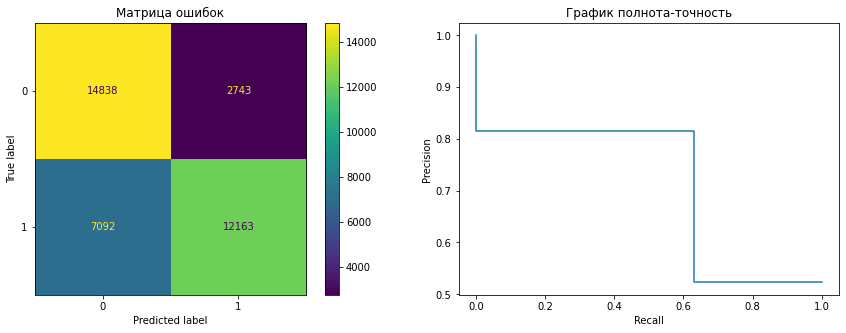

In [58]:
cm = confusion_matrix(y_test, prediction_gbm, labels=gs_gbm.classes_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmd = ConfusionMatrixDisplay(cm, display_labels=gs_gbm.classes_)
cmd.plot(ax=ax1)
ax1.set_title('Матрица ошибок')
prec, recall, _ = precision_recall_curve(y_test, prediction_gbm)
PrecisionRecallDisplay(prec, recall).plot(ax=ax2)
ax2.set_title('График полнота-точность')
plt.show()

In [ ]:
X_encoded = gs_gbm.best_estimator_['columntransformer'].fit_transform(X)
model = gs_gbm.best_estimator_['lgbmclassifier'].fit(X_encoded, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_encoded)

shap.summary_plot(shap_values, X)

На ДТП больше всего влияют:

- наличие контрольного устройства в машине
- погодные условия
- состояние дороги
- тип трансмиссии

## Выводы

Ожидаемые результаты с контрольным устройством. Его наличие и работоспособность влияет на вероятность ДТП. Также влияет погода, что тоже логично - в дождь и снег плохая видимость и вероятность ДТП выше. Удивительно высоко забралось наличие высокой страховки.


Заказчику можно порекомендовать:

оборудовать все автомобили устройствами контроля (видеокамерой в салон) и извещать об этом пользователей;
приобретать АМ с автоматической КПП.

В нашем исследовании мы сделали следующее:
- Загрузили и распределили таблицы
- Выполнили исследовательский анализ
- Подготовили выборки, оставив только необходимые столбцы
- Обучили модели
- Проанализировали результаты и подвели итоги
Модели показали хорошую метрику F1 (выше 0.7 у обеих моделей). Они полностью работоспособны и могут предугадывать ДТП в каршеринге/